# MLP : Batch Normalization 

## Part 4 : Batch Normalization
---
Normalize the output of a linear before it goes to activation.

This is possible as all the normalization does is get mean and standard deviation, and divide them to normalize it. This is completely differntiable and hence works for backprop


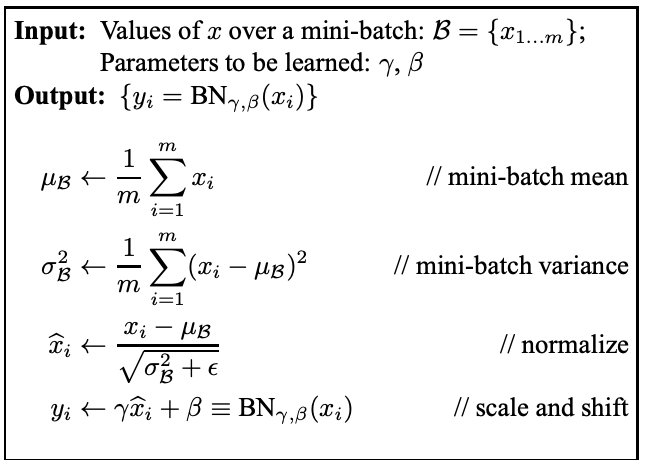

---

Kaiming init Paper : https://arxiv.org/pdf/1502.01852.pdf

BatchNorm Paper : https://arxiv.org/pdf/1502.03167.pdf

In [1]:
from typing import List
import random

In [2]:
import torch
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

In [3]:
import torch.nn.functional as F

## 1. Data Gathering

In [4]:
words = open('data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

## 2. Data Pre-Processing

In [6]:
START = END = '.'
CHARS = sorted(list(set(''.join(words))) + [START])

stoi = {char:idx for idx, char in enumerate(CHARS)}
itos = {i:s for s, i in stoi.items()}

In [7]:
print(f"\n{CHARS=}")
print(f"\n{stoi=}")
print(f"\n{itos=}")


CHARS=['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

stoi={'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}

itos={0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


### 2.1 NGrams Split

In [8]:
def get_ngrams(words: List[str], ngrams=3, debug=False):
    X, Y = list(), list()
    
    for word in words:
        if debug: print(f"-- {word} --")
        context_idxs = [stoi[START]] * (ngrams-1)
        
        for char in word+END:
            pred_idx = stoi[char]
            Y.append(pred_idx)
            X.append(context_idxs)
            
            if debug: print(f"{''.join(itos[i] for i in context_idxs)} {itos[pred_idx]}")
            context_idxs = context_idxs[1:] + [pred_idx]
            
    return torch.tensor(X), torch.tensor(Y)

In [9]:
NGRAMS = 4
CONTEXT_SIZE = NGRAMS - 1

#### 2.1.1 Train Test split

In [10]:
def split_data(data: List, ratio: float = 0.8):
    split_idx = int(ratio*len(data))
    return data[:split_idx], data[split_idx:]


In [11]:
random.shuffle(words)

train_words, test_words = split_data(data=words, ratio=0.8)
val_words, test_words = split_data(data=test_words, ratio=0.5)

assert len(words) == len(train_words) + len(val_words) + len(test_words)
len(train_words), len(val_words), len(test_words)

(25626, 3203, 3204)

In [12]:
# Complete Dataset

X_train, Y_train = get_ngrams(words=train_words, ngrams=NGRAMS, debug=False)
X_val, Y_val = get_ngrams(words=val_words, ngrams=NGRAMS, debug=False)
X_test, Y_test = get_ngrams(words=test_words, ngrams=NGRAMS, debug=False)


X_train.shape, Y_train.shape

(torch.Size([182504, 3]), torch.Size([182504]))

## 3. MLP

### 3.1 Architecture
From paper : [A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

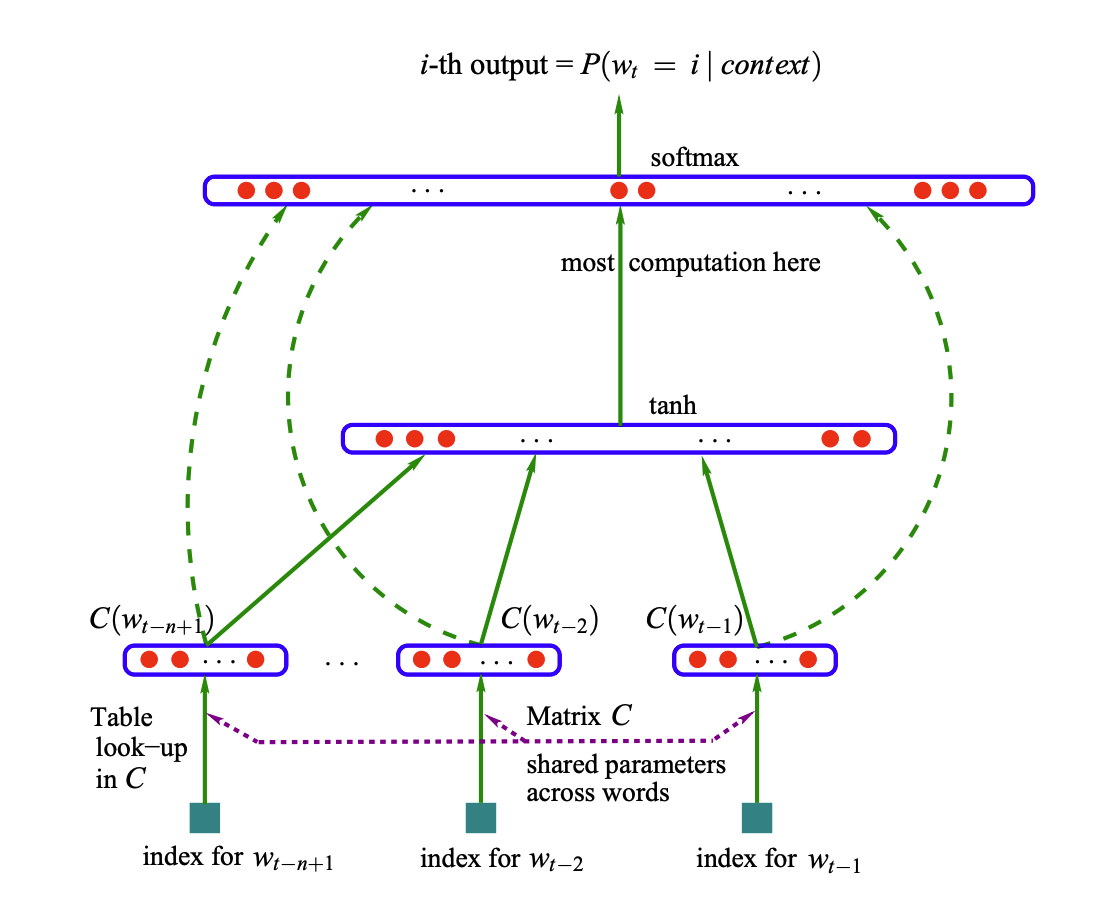

In [13]:
class MLP:
    
    def __init__(self, vocab_size, n_embd, n_positions, seed=4744):
        
        self._device = 'cpu'
        
        # Seed for reproducibility
        g = torch.Generator().manual_seed(seed)

        # Embeding Layer
        self.C = torch.randn((vocab_size, n_embd), generator=g)    

        # Hidden Layer
        self.W1 = torch.randn((CONTEXT_SIZE * n_embd, n_positions), generator=g) * (5/3)/((CONTEXT_SIZE*n_embd)**0.5)
        self.b1 = torch.randn((n_positions),                        generator=g) * 0.01

        # Output Layer
        self.W2 = torch.randn((n_positions, vocab_size),            generator=g) * 0.01     # close to 0
        self.b2 = torch.randn((vocab_size),                         generator=g) * 0        # BIAS output as 0, as we need uniform predictions for all characters.

        # Parameters
        #self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
        print(f"Number of Model Params: {sum(p.nelement() for p in self.parameters)}")

        # Require Grads , for backprop
        self.require_grads()

    @property
    def parameters(self):   
        return [self.C, self.W1, self.b1, self.W2, self.b2]
    
    @property
    def device(self):
        return self._device
    
    def require_grads(self):
        for p in self.parameters: p.requires_grad = True
            
    def __call__(self, x):
        
        # Forward call
        self.emb = self.C[x]     
        self.hpreact = self.emb.view(self.emb.shape[0], -1) @ self.W1 + self.b1
        self.h = torch.tanh(self.hpreact) 
        self.logits = self.h @ self.W2 + self.b2                                        
        return self.logits
  
    def to(self, device):
        if not torch.cuda.is_available():
            print(f"Cuda not available")
            return
        
        self.C = self.C.detach().to(device)
        self.W1 = self.W1.detach().to(device)
        self.b1 = self.b1.detach().to(device)
        self.W2 = self.W2.detach().to(device)
        self.b2 = self.b2.detach().to(device)
            
        self._device = device
        self.require_grads()

### 3.2 Training Loop

In [14]:
class Trainer:
    
    def __init__(self, model):
        self.model = model
        self.losses = list()
        self.epochs = 0
    
    @staticmethod
    def get_batch_idxs(x, batch_size):
        return torch.randint(0, x.shape[0], size=(batch_size,))
        
    def train(self, x, y, batch_size=32, epochs=10, lrs=(0.1, 0.01), lr_decay_epoch=5):
        print(f"Dataset size: {len(x)}")
        epochs += self.epochs
        delta_epochs = epochs - self.epochs
        
        for epoch in tqdm(range(self.epochs, epochs), desc="Epochs"):
            # Batch indexes
            ix = self.get_batch_idxs(x, batch_size=batch_size)
            _x = x[ix].to(self.model.device)
            _y = y[ix].to(self.model.device)
            
            # Forward
            logits = self.model(_x)
            loss = F.cross_entropy(logits, _y)
            if epoch in {self.epochs} or epoch % int(delta_epochs/10) == int(delta_epochs/10) - 1: print(f"Loss {epoch+1}/{epochs}: {loss.item()}")
            self.losses.append(loss.item())

            # Backward
            for p in model.parameters: p.grad = None
            loss.backward()

            # Optimizer
            lr = lrs[0] if epoch > lr_decay_epoch else lrs[1]
            for p in model.parameters: p.data -= lr * p.grad
            
        self.epochs += delta_epochs
        return self.losses
    
    @torch.no_grad()
    def evaluate(self, x, y):
        x = x.to(self.model.device)
        y = y.to(self.model.device)
        
        logits = self.model(x)
        loss = F.cross_entropy(logits, y)
        return loss
    
    def plot(self):
        if len(self.losses) <= 1:
            print(f"Model Final loss: {self.losses[-1]}")
            return
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
        fig.figsize=(20, 10)
        ax1.plot(self.losses); ax1.set(title="Loss", xlabel="Epochs", ylabel="loss")
        ax2.plot(list(map(torch.log10, torch.tensor(self.losses)))); ax2.set(title="Log Loss", xlabel="Epochs", ylabel="loss = 10^x") 
        print(f"Model Final loss: {self.losses[-1]}")

#### 3.2.1 Training

In [15]:
N_EMBD = 30
N_POSITIONS = 200

BATCH_SIZE = 32

In [16]:
# INIT MODEL

model = MLP(vocab_size=len(CHARS), n_embd=N_EMBD, n_positions=N_POSITIONS)
model.to("cuda:1")
model.C.device

Number of Model Params: 24437


device(type='cuda', index=1)

In [17]:
# Init Trainer
trainer = Trainer(model=model)

In [18]:
# Train 

losses = trainer.train(x=X_train, y=Y_train, batch_size=BATCH_SIZE, epochs=1, lrs=(0.1, 0.01), lr_decay_epoch=100_000)
trainer.plot()

Dataset size: 182504


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Loss 1/1: 3.2764110565185547
Model Final loss: 3.2764110565185547


#### 3.2.2 Observation

Normalization of hpreact

In [19]:
model.hpreact, model.hpreact.shape

(tensor([[ 0.3293,  3.2659,  1.6135,  ..., -1.1293,  1.4255, -4.7167],
         [ 2.5352, -1.9139, -1.4803,  ..., -1.6006,  0.2256, -2.9291],
         [-1.4024,  2.1562,  0.4578,  ..., -1.0509, -0.5776, -1.7293],
         ...,
         [-0.9576, -0.1296,  1.8690,  ...,  2.1376, -2.7143, -0.5931],
         [ 2.9324, -2.8004, -0.4520,  ..., -0.5021,  0.1409, -1.2282],
         [ 0.9642, -2.3695, -2.1895,  ..., -0.6819, -1.6955, -1.4412]],
        device='cuda:1', grad_fn=<AddBackward0>),
 torch.Size([32, 200]))

#### 3.3 Normalization:

##### 3.3.1 Mean of Neuron

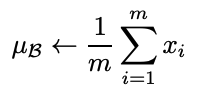

In [21]:
model.hpreact.mean(0, keepdims=True).shape

torch.Size([1, 200])

##### 3.3.2 Standard Deviation of neuron

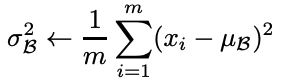

In [22]:
model.hpreact.std(0, keepdims=True).shape

torch.Size([1, 200])

##### 3.3.3 normalize

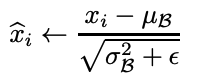

Epislon is ignored for now, or can take a very small value

In [24]:
normalized_hpreact = (model.hpreact - model.hpreact.mean(0, keepdims=True)) / (model.hpreact.std(0, keepdims=True))**0.5
normalized_hpreact, normalized_hpreact.shape

(tensor([[ 0.1906,  2.5279,  1.2215,  ..., -0.4427,  1.8192, -2.7438],
         [ 1.7957, -1.3139, -1.0585,  ..., -0.7959,  0.7889, -1.3906],
         [-1.0694,  1.7048,  0.3698,  ..., -0.3840,  0.0992, -0.4824],
         ...,
         [-0.7458,  0.0095,  1.4098,  ...,  2.0051, -1.7355,  0.3777],
         [ 2.0848, -1.9713, -0.3007,  ...,  0.0272,  0.7162, -0.1030],
         [ 0.6526, -1.6518, -1.5812,  ..., -0.1075, -0.8607, -0.2643]],
        device='cuda:1', grad_fn=<DivBackward0>),
 torch.Size([32, 200]))

##### 3.3.4 Scale and Shift

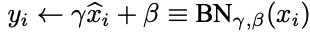

**Updates for Batch Normalization**

   1. Trainable Params
       1. Gamma : Scale : Gain --> these are trained during training step.
       1. Beta : Shift : Bias  --> these are also trained during training step.
  
   2. Non Trainable Params
       1. Mean : Running mean
       1. Standard Deviation : Running std
       
       (These are calculated as running Mean and running Std with a momentum.)
       Momentum is the rate or fraction at which the running variables are updated.
       
   3. Note: When you have BatchNorm, you have a bias of it, so we don't need a bias for the layer before it.
   
   4. Typical flow [Layer --> BatchNorm --> Activation]
       
**WOULD BE DONE IN NEXT NOTEBOOK**